In [8]:
## https://www.assemblyai.com/blog/pytorch-lightning-for-dummies/

In [24]:
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from collections import OrderedDict

import matplotlib.pyplot as plt

import pytorch_lightning as pl


random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE=128
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2)

In [6]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data", 
                 batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [19]:
# Detective: fake or no fake -> 1 output [0, 1]
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # Simple CNN
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)
  
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten the tensor so it can be fed into the FC layers
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [18]:
# Generate Fake Data: output like real data [1, 28, 28] and values -1, 1
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)  # [n, 256, 7, 7]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # [n, 64, 16, 16]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # [n, 16, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7)  # [n, 1, 28, 28]
    

    def forward(self, x):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)  #256
        
        # Upsample (transposed conv) 16x16 (64 feature maps)
        x = self.ct1(x)
        x = F.relu(x)
        
        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x)
        x = F.relu(x)
        
        # Convolution to 28x28 (1 feature map)
        return self.conv(x)

In [47]:

class GAN(pl.LightningModule):
    ## Initialize. Define latent dim, learning rate, and Adam betas 
    def __init__(self, latent_dim=100, lr=0.0002, 

                 b1=0.5, b2=0.999, batch_size=128):
        super().__init__()
        self.save_hyperparameters()

        self.generator = Generator(latent_dim=self.hparams.latent_dim)
        self.discriminator = Discriminator()

        self.validation_z = torch.randn(8, self.hparams.latent_dim)
    
    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)
    
    def configure_optimizers(self):
        lr = self.hparams.lr
        b1 = self.hparams.b1
        b2 = self.hparams.b2

        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(b1, b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1, b2))
        return [opt_g, opt_d], []
    
    def training_step(self, batch, batch_idx, optimizer_idx):
        real_imgs, _ = batch

        # sample noise
        z = torch.randn(real_imgs.shape[0], self.hparams.latent_dim)

        # train generator
        if optimizer_idx == 0:
            self.generated_imgs = self(z)
            predictions = self.discriminator(self.generated_imgs)
            g_loss = self.adversarial_loss(predictions, torch.ones(real_imgs.size(0), 1))
            

            # log sampled images
            sample_imgs = self.generated_imgs[:6]
            grid = torchvision.utils.make_grid(sample_imgs)
            self.logger.experiment.add_image("generated_images", grid, 0)


            tqdm_dict = {"g_loss": g_loss}
            output = {"loss": g_loss, "progress_bar": tqdm_dict, "log": tqdm_dict}
            return output

        # train discriminator
        if optimizer_idx == 1:
            real_preds = self.discriminator(real_imgs)
            real_loss = self.adversarial_loss(real_preds, torch.ones(real_imgs.size(0), 1))

            fake_preds = self.discriminator(self(z).detach())
            fake_loss = self.adversarial_loss(fake_preds, torch.zeros(real_imgs.size(0), 1)) 


            d_loss = (real_loss + fake_loss) / 2
            tqdm_dict = {"d_loss": d_loss}
            output = {"loss": d_loss, "progress_bar": tqdm_dict, "log": tqdm_dict}
            return output
        
    def on_epoch_end(self):
        # log sampled images
        sample_imgs = self(self.validation_z)
        grid = torchvision.utils.make_grid(sample_imgs)
        self.logger.experiment.add_image("generated_images", grid, self.current_epoch)
        self.plot_img()
        
    def plot_img(self):
        z = self.validation_z.type_as(self.generator.lin1.weight)
        sample_imgs = self(z).cpu()
        
        print('epoch', self.current_epoch)
        fig = plt.figure()
        for i in range(sample_imgs.size(0)):
            plt.subplot(2,4,i+1)
            plt.tight_layout()
            plt.imshow(sample_imgs.detach()[i,0,:,:], cmap='gray_r', interpolation='none')
            plt.title("Generated Data")
            plt.xticks([])
            plt.yticks([])
            plt.axis('off')
        plt.show()

In [48]:

trainer = pl.Trainer(max_epochs=20)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs



  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 358 K 
1 | discriminator | Discriminator | 21.4 K
------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

epoch 0


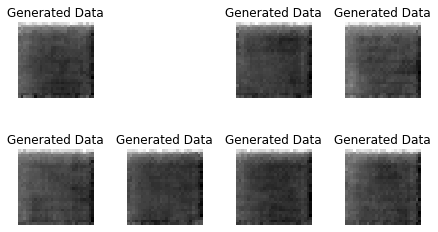

epoch 1


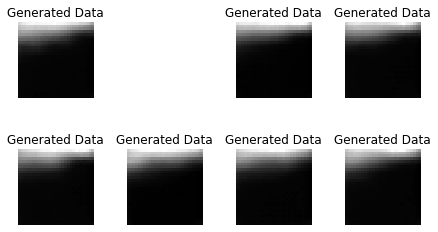

epoch 2


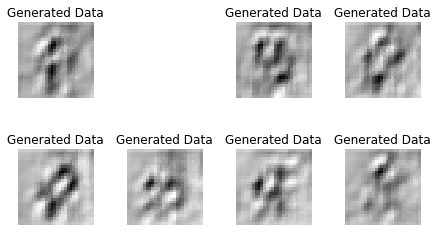

epoch 3


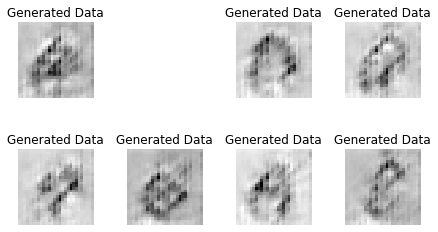

epoch 4


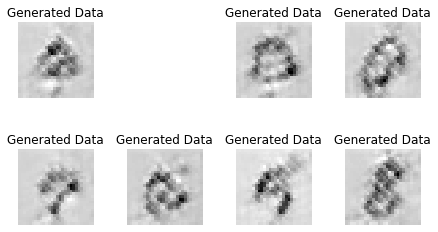

epoch 5


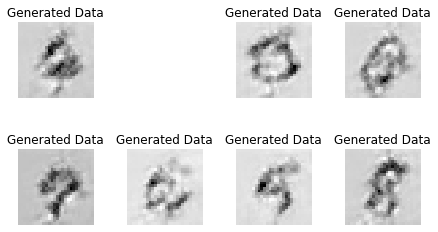

epoch 6


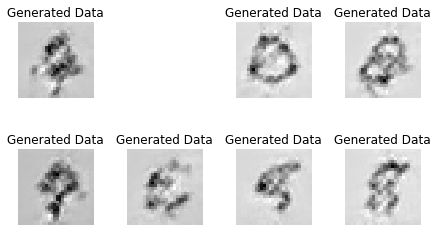

epoch 7


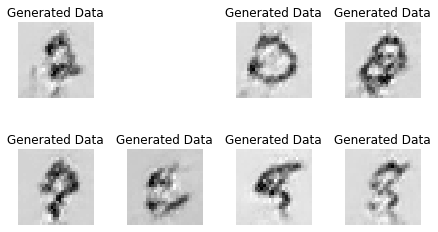

epoch 8


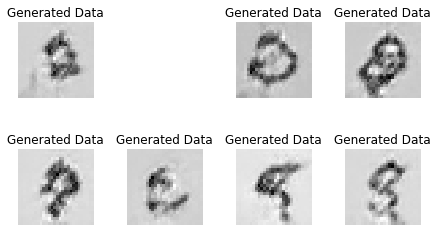

epoch 9


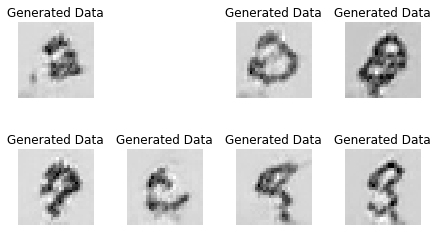

epoch 10


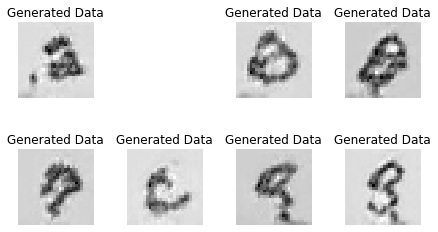

epoch 11


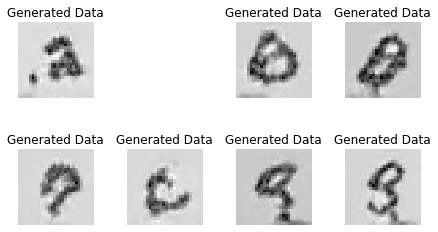

epoch 12


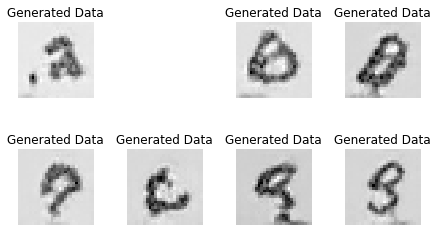

epoch 13


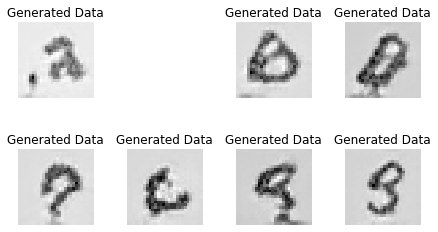

epoch 14


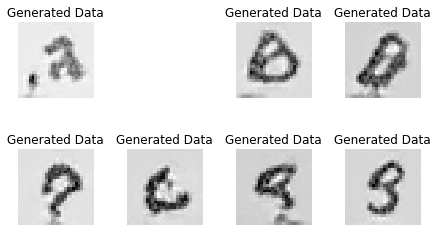

epoch 15


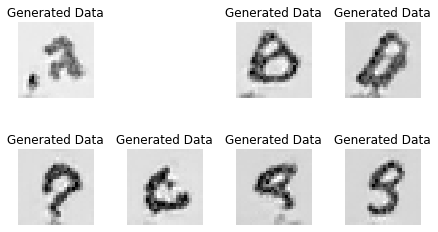

epoch 16


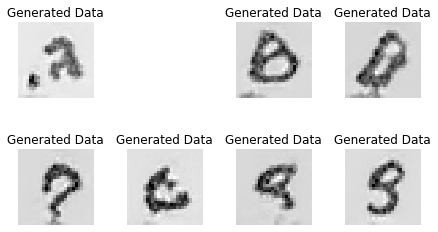

epoch 17


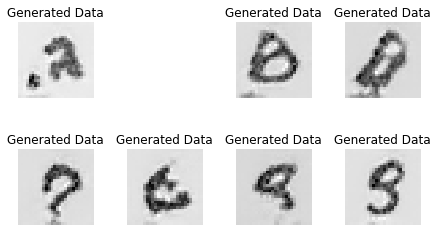

epoch 18


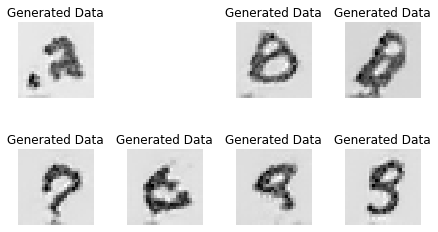

epoch 19


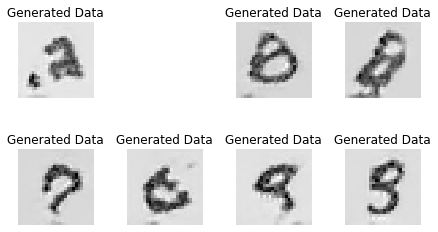

In [49]:
dm = MNISTDataModule() 
model = GAN()
trainer.fit(model, dm)